# Arabic Learner Corpus Considerations: Data Analysis <a name="TOP"></a>
Anthony Verardi | a.verardi@pitt.edu | 3/17/2020 | University of Pittsburgh

In this Notebook (which is a continuation of [ALC Data Organization](https://github.com/Data-Science-for-Linguists-2020/Arabic-Learner-Corpus-Considerations/blob/master/Notebooks/ALC_Data_Organization.ipynb)), I'll begin the process of preparing the data obtained from the [Arabic Learner Corpus](https://www.arabiclearnercorpus.com/) for analysis. I will provide some interpretation here in this Notebook, but for full analysis, please visit my [final_report.md](https://github.com/Data-Science-for-Linguists-2020/Arabic-Learner-Corpus-Considerations/blob/master/final_report.md) file in my project's [home repository](https://github.com/Data-Science-for-Linguists-2020/Arabic-Learner-Corpus-Considerations).

Corpus credit to: 
> Alfaifi, A., Atwell, E. and Hedaya, I. (2014). Arabic Learner Corpus (ALC) v2: A New Written and Spoken Corpus of Arabic Learners. In the proceedings of the Learner Corpus Studies in Asia and the World (LCSAW) 2014, 31 May - 01 Jun 2014. Kobe, Japan. http://www.arabiclearnercorpus.com.

**Table of Contents**
1. [Data Preparation](#DP)
1. [Visualizations of Subgroups](#subgroups)
    1. [Visualizing Full Corpus Text Lengths](#FCTL)
    1. [Visualizing Text Lengths by L1 Family](#TLL1)
    1. [Visualizing Text Lengths by Nativeness](#TLNS) 
1. [MNB Classification of L1](#classifier)
    1. [L1 Family MNB Classifier Tweaking with `GridsearchCV`](#GCV)
    1. [L1 Family Final Classifier Training, Testing, and Evaluation](#FINMNB)
    1. [Nativeness MNB Classifier Tweaking with `GridsearchCV`](#GCV2)
    1. [Nativeness Final Classifier Training, Testing, and Evaluation](#FINMNB2)
    
## Section 1: Data Preparation <a name="DP"></a>
Before we can do anything, we'll need to import necessary packages and read in the dataframe that we curated in the [ALC Data Organization](https://github.com/Data-Science-for-Linguists-2020/Arabic-Learner-Corpus-Considerations/blob/master/Notebooks/ALC_Data_Organization.ipynb) Notebook.

In [1]:
# Importing necessary packages to begin analyzing our data

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline

# Allowing for multiple lines of output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Now that we have our necessary packages ready to go, let's read in our `DataFrame` from the Organization Notebook and make certain that everything's still there.

In [2]:
df = pd.read_pickle("ALC_df.pkl")

In [3]:
df.head()

,Nativeness,L1,NumLangs,Nationality,Age,Gender,YearsStudy,GenLvl,LvlStdy,Title,Text,Genre,Mode,TextToks,TitleToks,TextLen,TitleLen,TTR,L1family
DocID,,,,,,,,,,,,,,,,,,,
S001_T1_M_Pre_NNAS_W_C,NNAS,Moore,4,Burkina Faso,20,Male,14,Pre-university,Diploma course,الرحلة إلى القرية لزيارة ذوي القربى,اعتدت الذهاب إلى قريتي في الإجازات الصيفيّة ال...,Narrative,Written,"[اعتدت, الذهاب, إلى, قريتي, في, الإجازات, الصي...","[الرحلة, إلى, القرية, لزيارة, ذوي, القربى]",169,6,0.798817,NigerCongo
S001_T2_M_Pre_NNAS_W_C,NNAS,Moore,4,Burkina Faso,20,Male,14,Pre-university,Diploma course,الجمع بين العلم الشرعي والعلوم الدنيوية لحمزة ...,أحبّ أن ألتحق بكلِّية الشريعة بعد الانتها من ا...,Discussion,Written,"[أحبّ, أن, ألتحق, بكلِّية, الشريعة, بعد, الانت...","[الجمع, بين, العلم, الشرعي, والعلوم, الدنيوية,...",161,9,0.844720,NigerCongo
S002_T1_M_Pre_NNAS_W_C,NNAS,Russian,5,Russian,25,Male,5,Pre-university,Diploma course,رحلة الحج المباركة,كتب الله لي أن أحج إلى بيته الحرام السنة الماض...,Narrative,Written,"[كتب, الله, لي, أن, أحج, إلى, بيته, الحرام, ال...","[رحلة, الحج, المباركة]",317,3,0.637224,BaltoSlavic
S002_T2_M_Pre_NNAS_W_C,NNAS,Russian,5,Russian,25,Male,5,Pre-university,Diploma course,أكثر من التخصص,الحمد لله الذي وفقني لدراسة شرعية في جامعة الإ...,Discussion,Written,"[الحمد, لله, الذي, وفقني, لدراسة, شرعية, في, ج...","[أكثر, من, التخصص]",173,3,0.757225,BaltoSlavic
S003_T1_M_Pre_NNAS_W_C,NNAS,Tatar,4,Russian,24,Male,6,Pre-university,Diploma course,رحلتي إلى الجبال,في أحد الأيام الصيف أخبرنا أبي بسفرٍ إلى الغاب...,Narrative,Written,"[في, أحد, الأيام, الصيف, أخبرنا, أبي, بسفرٍ, إ...","[رحلتي, إلى, الجبال]",133,3,0.766917,Turkic


Beautiful! Pickling works like a charm. On to the actual analysis portion of this Notebook.

[Back to Top](#TOP)
## Section 2: Visualizations of Subgroups <a name="subgroups"></a>
We already know from our organization notebook that the L1 data are not normally distributed, but what about the lengths of the texts themselves? I'm interested in knowing exactly what we'll be feeding our classifier as training data in part 2; intuition inclines me to believe that training a model on groups with not only different numbers of texts but also lengths of text might not bode well for results. We'll visualize both the raw counts for each to get an idea of how much data our classifier could potentially be working with in part 2 of this Notebook. First we'll just look at the raw values, then we'll break them out across L1 partitions and then by Nativeness.

### 2A. Visualizing Full Corpus Text Lengths <a name="FCTL"></a>

Text(0.5, 1.0, 'Text Length Distribution for the Full ALC')

Text(0.5, 0, 'Text Length')

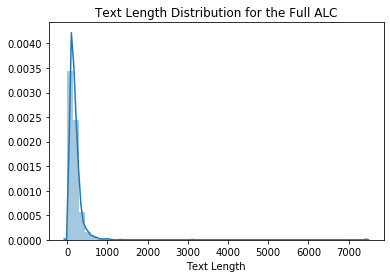

In [4]:
fig, ax = plt.subplots()
sns.distplot(df['TextLen'], ax=ax)
plt.title("Text Length Distribution for the Full ALC")
plt.xlabel("Text Length")
plt.show()

Not the prettiest plot in the world, but it gets the job done. Text length itself is most certainly skewed to the right when looking at the full group, with a majority of values clustered in the sub-1000 range and some outliers up to the 7000-character range. Let's recreate the same plot, but zoom in and use 1000 as an artificial cutoff point, just so that it's easier to examine the brunt of the data. 


Text(0.5, 1.0, 'Text Length Distribution for the Full ALC, Truncated')

Text(0.5, 0, 'Text Length')

(0, 1000)

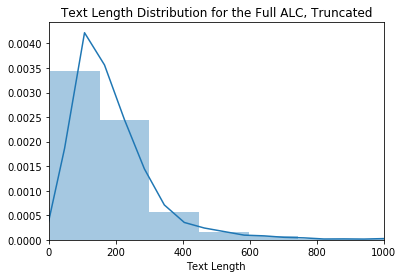

In [5]:
fig, ax = plt.subplots()
sns.distplot(df['TextLen'], ax=ax)
plt.title("Text Length Distribution for the Full ALC, Truncated")
plt.xlabel("Text Length")
ax.set_xlim(0,1000)
plt.show()

This is much easier to look at, and from this we can see that the distribution of the data (while still certainly right-skewed) centers around 200 tokens (recalling that our mean text length is 184 word tokens, this makes sense). The median value of 149 word tokens will be more helpful later, since this value is more useful as a measure of central tendency in right-skewed data.
### 2B. Visualizing Text Lengths by L1 Family <a name="TLL1"></a>
Let's see what it looks like when we break things down by L1 family; for this, we'll use violin plots for ease of comparison. Unlike boxplots, violin plots also reflect the density of the values, with the vertical line above reflecting potential outlines/values that only occur a few times. We'll use the same cutoff of 1000 words here that we used above for the sake of readability.

<Figure size 1080x360 with 0 Axes>

Text(0.5, 1, 'Text Length Distribution by L1 Family')

Text(0.5, 6.79999999999999, 'L1 Family')

Text(-2.450000000000003, 0.5, 'Text Length')

(0, 1000)

<Figure size 1080x360 with 0 Axes>

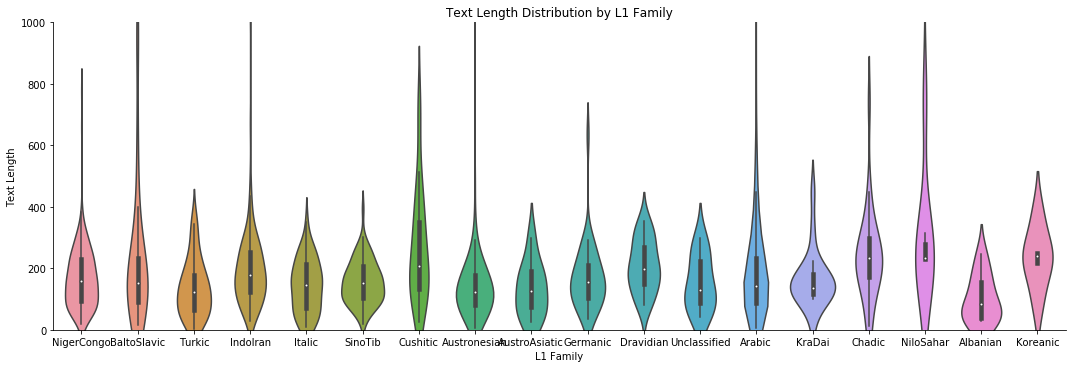

In [6]:
plt.figure(figsize=(15,5))
sns.catplot(x="L1family", y="TextLen", kind='violin', height=5, aspect=3, data = df)
plt.title("Text Length Distribution by L1 Family")
plt.xlabel("L1 Family")
plt.ylabel("Text Length")
plt.ylim(0, 1000)

As mentioned above, violin plots reflect the density of the values that they represent. We can take the "fattest" part of the violin as the point around which most of the data in that category is clustered, with uniformity of thickness indicating how disperse the non-median observations are. These data appear to pattern similarly to each other, although BaltoSlavic, Cushitic, Arabic, and NiloSahar appear more similar to each other than to the rest of the data; Koreanic and Albanian are unique as well.
### 2C. Visualizing Text Lengths by Nativeness <a name="TLNS"></a>

<Figure size 720x720 with 0 Axes>

Text(0.5, 1, 'Text Length Distribution by Nativeness')

Text(-2.450000000000003, 0.5, 'Text Length')

(0, 1000)

<Figure size 720x720 with 0 Axes>

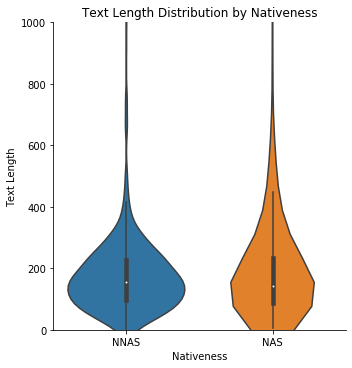

In [7]:
plt.figure(figsize=(10,10))
sns.catplot(x="Nativeness", y="TextLen", kind='violin', data = df)
plt.title("Text Length Distribution by Nativeness")
plt.ylabel("Text Length")
plt.ylim(0, 1000)

Based on these plots, it seems safe to conclude that as long as the training data we use is randomly distributed in a way that captures the same balance of the original corpus, the classifier should get relatively similar input from each of the L1 families. I'm also beginning to think that because the Nativeness comparison shows the most siimilar shapes for the violin plots, it may indicate that this is the best comparison to use for a classifier. Although we may lose granularity and the ability to look at how it handles particular language families (and accordingly lose insight into what features in their writing are informative), we will likely see a more accurate model that can give us better overall insights into non-native speaker learner writing compared to native speaker learner writing.

[Back to Top](#TOP)
## Section 3: MNB Classification of L1 <a name="classifier"></a>
In this section, we'll investigate whether this dataset is usable for training a Multinomial Naïve-Bayes classifier to predict first the L1 family of the writer based on their text sample and then separately the nativeness of the writer based, again, on their text.

My line of thinking is that if the classifier is able to successfully separate the learners from the native speakers, the most informative features it uses may also be helpful for highlighting facets of language that may inform what instructors should focus on in pedagogical interventions for similar learners. Because there are so many different L1s represented in the dataset with so few participants per L1 in most cases, collapsing them into larger families seemed logical; we will therefore use the L1 family data. After this, we will try to build another classification model using the native speaker vs. non-native speaker "Nativeness" category as our label instead.

### 3A. L1 Family MNB Classifier Tweaking with `GridsearchCV` <a name="GCV"></a>
First, we'll start off by using `GridsearchCV` to tweak the parameters of our model and find what works best.

In [8]:
# Setting the type of classifier and vectorizer to use
mnb = MultinomialNB()
tfIdf = TfidfVectorizer()

# Building a pipeline that will first vectorize the texts and second use them to build
# a Multinomial Naive-Bayes classifier 
pipe = Pipeline(steps=[('tfIdf', tfIdf),('mnb',mnb)])

# Using GridsearchCV to test different parameter levels
clf = GridSearchCV(pipe, param_grid = {"tfIdf__max_features":[1000, 2000, 5000], 
                                      "tfIdf__min_df":[1,2,3],
                                       "tfIdf__max_df":[.25, .5, .75],
                                      "mnb__fit_prior":(True, False)}, cv=5, return_train_score=True)

clf.fit(df.Text, df.L1family)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfIdf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                         

In [9]:
# Fetching the best parameters from the above models
clf.best_params_

{'mnb__fit_prior': False,
 'tfIdf__max_df': 0.25,
 'tfIdf__max_features': 2000,
 'tfIdf__min_df': 1}

In [10]:
# Building a dataframe of the entire results from each model
df2 = pd.DataFrame.from_dict(clf.cv_results_)

# Displaying aggregate descriptive statistics for all of the models 
df2[['mean_test_score', 'mean_train_score']].describe()

,mean_test_score,mean_train_score
count,54.000000,54.000000
mean,0.557367,0.682918
std,0.032304,0.092228
min,0.504732,0.537691
25%,0.539590,0.609228
50%,0.552997,0.674288
75%,0.579022,0.768721
max,0.615773,0.811505


The combination of parameters gave us a whopping 54 different permutations of our classifier, with a mean accuracy across all models of 55.74% and a standard deviation of 3.23%. Compared to the baseline of 49% of the samples being in Arabic to begin with, this isn't great performance. The max test score was 61.58% accuracy, which is better, but still not really anything to write home about when the version we trained on the ETS corpus was able to get into the 70s for accuracy with a much lower baseline.

### 3B. L1 Family Classifier Training, Testing, and Evaluation <a name="FINMNB"></a>
Now that we have our best parameters, we'll train one model that makes use of them so that we can then use a confusion matrix to look at the actual performance by L1 family.

In [11]:
text_train, text_test, y_train, y_test = train_test_split(df['Text'], df['L1family'], test_size = .2, random_state=0)

MNB_model = make_pipeline(TfidfVectorizer(max_features = 2000, min_df=1, max_df=.25), 
                          MultinomialNB(fit_prior = False))

MNB_model.fit(text_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.25, max_features=2000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('multinomialnb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False))],
         verbose=False)

In [12]:
# Predictions
predictions = MNB_model.predict(text_test)

# Matrix
matrix = confusion_matrix(y_test, predictions)

# Accuracy assessment
accuracy = accuracy_score(y_test, predictions)
accuracy

0.6309148264984227

The accuracy of this model is actually slightly above the highest-scoring model we were able to get when using five-fold cross-validation earlier, which is likely due to the different training/testing split employed here. Let's take a look at how it did in detail using a confusion matrix.

<Figure size 864x864 with 0 Axes>

(18.0, 0.0)

Text(0.5, 152.97257142857137, 'True L1 Family')

Text(87.0, 0.5, 'Predicted L1 Family')

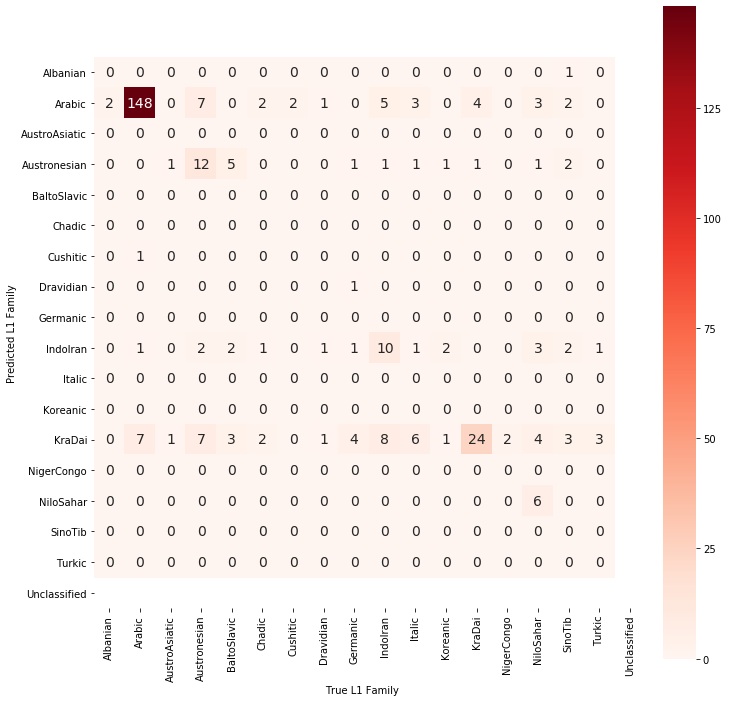

In [13]:
plt.figure(figsize=(12,12))

ax2 = sns.heatmap(matrix.T, square=True, annot=True, fmt='d', cmap='Reds', annot_kws={"size": 14},
            xticklabels= np.unique(df['L1family']), yticklabels= np.unique(df['L1family']))

bottom, top = ax2.get_ylim()

ax2.set_ylim(bottom + 0.5, top - 0.5) 

plt.xlabel('True L1 Family')
plt.ylabel('Predicted L1 Family')
plt.show()

So, this leaves us with the preliminary question: how is this classifier doing? When considering that the Arabic L1 data make up 790 out of the 1,585 observations (~49.84%), an accuracy of around 63% does not seem great. We've got an almost 50% chance at getting the right label just by labeling everything as Arabic and calling it a day. Even after collpapsing the data into families, it doesn't seem like it's been able to overcome the sheer imbalance of data that's presented here for training a classifier. It does seem to be performing better on the Austronesian, Indo-Iranian, and the Kra-Dai families. More to come, but for preliminary results, I think things are shaping up.

Finally, we'll try to look at the most informative features that our model gives us. 

In [14]:
# Thanks, stack overflow!
# https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

# modified to handle n-grams and flexible top number
def print_top(vzr, clf, class_labels, n):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vzr.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top = np.argsort(clf.coef_[i])[0-n:]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j].replace(' ', '-') for j in top)))
             # ^ comma-separate                      ^^^ hyphenate multi-word features (=n-grams) if any 

# Vectorizer and classifier are steps in the pipeline. Must retrieve. 
vzr = MNB_model.steps[0][1] 
clf2 = MNB_model.steps[1][1] 

print_top(vzr, clf2, clf2.classes_, 20)

Albanian: وبعدها, أدرس, المكة, بلدي, نعم, الدين, هنا, ماء, حول, أريد, دين, جدا, العربية, مكة, اللغة, الى, المكرمة, الناس, زوجي, يعني
Arabic: وفي, أو, رحلة, انا, الطب, المجال, اليوم, فيه, فيها, ولكن, جدا, وقد, لي, ومن, وكانت, ذهبنا, ان, وكان, التخصص, الى
AustroAsiatic: تم, إليها, سيدنا, أريد, جدا, المعهد, التخطيط, إن, العمرة, تعليم, الحديقة, محمد, اللغة, أصدقاء, كلية, الكلية, العربية, الدعوة, ماليزيا, قد
Austronesian: بعض, إن, الى, أريد, كلية, الإسلام, شاء, الشريعة, الكلية, مكة, بلدي, قد, اللغة, العربية, أو, الفلبين, فى, التخصص, الدين, لأن
BaltoSlavic: وأن, إلي, كما, كثيرا, الحرارة, المسلمين, كلية, لأن, جدا, بلدي, أريد, الإسلامية, الشريعة, زوجتي, المدينة, بل, اللغة, الوقت, الناس, العربية
Chadic: لكن, قبل, السلام, وفي, لغة, اللغة, عليه, بعض, بلدي, لما, مكة, وسلم, عنده, لله, محمد, الدين, الحمد, العربية, القرآن, الشريعة
Cushitic: عبد, بلدي, البلاغة, كما, مادة, الإمام, جامعة, السعودية, المدينة, القرى, أو, هي, التخصص, الي, الأدب, ال, اللغة, العربية, يعني, جيبوتي
Dravidian: لغة, العالمين, الم

As noted above, a more robust analysis of the most informative features will be present in my final_report.md file, but briefly:
* for native Arabic speakers, the most informative features display richer use of morphosyntactic elements and function words (differences in tense/aspect, prepositions) and fewer content words
* non-native Arabic speaker most informative features are dominated by rudimentary, concrete nouns one might expect low-proficiency learners to know
* there is an abundance of religious terms across the features by language

Having worked with our L1 family data, we will now turn to condensing our categories even further and work with "nativeness" as our target label.
### 3C. Nativeness MNB Classifier Tweaking with `GridsearchCV` <a name="GCV2"></a>
Here we'll see if reducing the language data categories further into native Arabic speaker learner of MSA and non-native Arabic speaker learner of MSA helps improve the accuracy of our model and what the most informative features look like as a result.

In [15]:
clf3 = GridSearchCV(pipe, param_grid = {"tfIdf__max_features":[1000, 2000, 5000], 
                                      "tfIdf__min_df":[1,2,3],
                                       "tfIdf__max_df":[.25, .5, .75],
                                      "mnb__fit_prior":(True, False)}, cv=5, return_train_score=True)

clf3.fit(df.Text, df.Nativeness)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfIdf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                         

In [16]:
clf3.best_params_

{'mnb__fit_prior': True,
 'tfIdf__max_df': 0.5,
 'tfIdf__max_features': 5000,
 'tfIdf__min_df': 3}

It's interesting to note that right off the bat, all of our best parameters for classifying Nativeness vs. L1 family are completely different. Maximum and minimum document frequency as well as maximum features have all gone up, and "True" is now the best setting for whether the model should fit priors or not.

In [17]:
df3 = pd.DataFrame.from_dict(clf3.cv_results_)

df3[['mean_test_score', 'mean_train_score']].describe()

,mean_test_score,mean_train_score
count,54.000000,54.000000
mean,0.912840,0.956835
std,0.009701,0.014493
min,0.897161,0.937539
25%,0.901104,0.938801
50%,0.918612,0.959069
75%,0.920347,0.972713
max,0.923659,0.973817


Reducing the number of categories further to native speaker learner vs. non-native speaker learner has dramatically improved the accuracy of our classifier, with the top classifier model now clocking in at 92.37% accuracy. The mean accuracy of all 54 models is 91.28% with a standard deviation of .97%, meaning that these models overall are also more consistent in spite of different parameter configurations than the previous models. 

### 3D. Nativeness Classifier Training, Testing, and Evaluation <a name="FINMNB2"></a>

Just as above, we'll use these best parameters to train one final model to evaluate.

In [18]:
text_train2, text_test2, y_train2, y_test2 = train_test_split(df['Text'], df['Nativeness'], test_size = .2, random_state=0)

MNB_model2 = make_pipeline(TfidfVectorizer(max_features = 5000, min_df=3, max_df=.5), 
                          MultinomialNB(fit_prior = True))

MNB_model2.fit(text_train2, y_train2)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=5000,
                                 min_df=3, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('multinomialnb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [19]:
# Predictions
predictions2 = MNB_model2.predict(text_test2)

# Matrix
matrix2 = confusion_matrix(y_test2, predictions2)

# Accuracy assessment
accuracy2 = accuracy_score(y_test2, predictions2)
accuracy2

0.8990536277602523

Our accuracy actually dipped here from what the top-performing model was able to achieve above! Again, this is likely due to differences in the training/testing partition.

<Figure size 864x864 with 0 Axes>

(2.0, 0.0)

Text(0.5, 279.23999999999995, 'True Nativeness')

Text(87.0, 0.5, 'Predicted Nativeness')

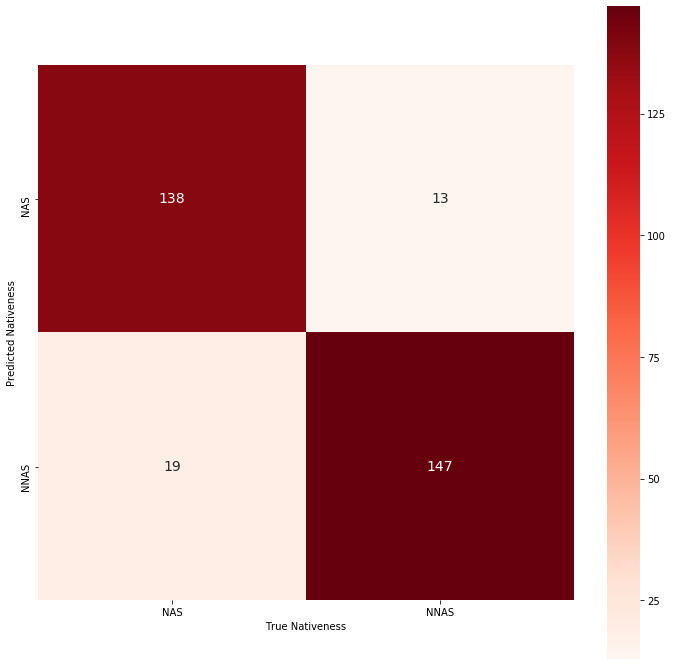

In [20]:
plt.figure(figsize=(12,12))

ax3 = sns.heatmap(matrix2.T, square=True, annot=True, fmt='d', cmap='Reds', annot_kws={"size": 14},
            xticklabels= np.unique(df['Nativeness']), yticklabels= np.unique(df['Nativeness']))

bottom, top = ax3.get_ylim()

ax3.set_ylim(bottom + 0.5, top - 0.5) 

plt.xlabel('True Nativeness')
plt.ylabel('Predicted Nativeness')
plt.show()

As the much-higher accuracy indicates, this model is performing far better than the the L1 family classifier, although this is certainly comparing apples to oranges (or really, apples to some non-fruit object. They're doing very different things). Given that our baseline should actually be about the same (roughly 50%), this is a huge improvement. We may have lost granular detail, but hopefully this will allow us to draw some final conclusions about what can be taken away from this dataset and this task. Lastly, I'll grab the 20 most informative features again and compare them to the prior ones once I write my final analysis.

In [21]:
# Normally we would use the same function as above, but having a binary classifier (NNAS or NAS)
# requires different code! This one just happens to come from the same Stack Overflow post
# as above
def important_features(vectorizer,classifier,n):
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()

    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]

    print("Important words for native Arabic speaker learners:")

    for coef, feat in topn_class1:
        print(np.round(coef, decimals=2), feat)

    print("-----------------------------------------")
    print("Important words for non-native Arabic speaker learners:")

    for coef, feat in topn_class2:
        print(np.round(coef, decimals=2), feat)            

vzr2 = MNB_model2.steps[0][1] 
clf4 = MNB_model2.steps[1][1]

important_features(vzr2, clf4,30)

Important words for native Arabic speaker learners:
27.75 الى
22.68 هذا
22.58 التخصص
20.65 ثم
19.05 كان
18.44 كانت
17.77 وكان
17.38 ما
16.76 ذهبنا
16.55 لا
16.5 ان
16.1 لم
15.07 وكانت
14.77 عن
14.12 التي
14.03 الرحلة
13.62 بعد
12.6 مع
12.54 هناك
12.38 ومن
12.34 الذي
12.14 لي
11.38 وقد
11.28 جدا
11.13 يوم
11.02 هو
10.8 هذه
10.68 ولكن
10.53 كل
10.48 فيها
-----------------------------------------
Important words for non-native Arabic speaker learners:
27.6 العربية
26.57 اللغة
25.11 هذه
22.49 هذا
20.64 ثم
19.83 بعد
18.87 الشريعة
18.47 لأن
18.46 الرحلة
17.17 التخصص
16.88 الدين
16.26 بلدي
16.0 فى
15.7 مكة
15.67 لا
15.64 كلية
15.28 ما
14.82 أريد
14.78 ذلك
14.34 الناس
14.11 مع
13.95 لله
13.91 الإسلام
13.28 كل
13.15 أو
12.86 القرآن
12.86 الإسلامية
12.79 أنا
12.72 حتى
12.42 وبعد


With all of this data in hand, it's time to write my final report on this project! Again, you can find it as [final_report.md](https://github.com/Data-Science-for-Linguists-2020/Arabic-Learner-Corpus-Considerations/blob/master/final_report.md) in my project's [home repository](https://github.com/Data-Science-for-Linguists-2020/Arabic-Learner-Corpus-Considerations).

[Back to Top](#TOP)